In [3]:
import pandas as pd
import re
from datasets import load_dataset
import datasets
import random
import numpy as np

C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def find_all_non_empty_masked_texts(text):
    # Regular expression to find all subsets of text between "### Masked text:" and "### End of text."
    pattern = r'### Masked text:(.*?)### End'
    matches = re.findall(pattern, text, re.DOTALL)
    # Filter out empty or newline-only matches
    non_empty_matches = [match for match in matches if match.strip()]
    if non_empty_matches:
        return non_empty_matches[0]
    else:
        return ""

In [3]:
test_string = """<|begin_of_text|>Identify and mask private identity information (PII) in the text.

### Text:
           "Evaluation Time": "6 PM"
            }
         },
         {
            "ID": "yibin.rocon",
            "Location": {
               "Country": "United Kingdom",
               "Building": "585",
               "Street": "Dunton Road",
               "City": "Billericay Crouch",
               "State": "ENG",
               "Postcode": "CM12 9TY"
            },
            "Personal Information": {
               "Sex": "Non-binary",
          

### Masked text:
           "Evaluation Time": "[TIME]"
            }
         },
         {
            "ID": "[USERNAME]",
            "Location": {
               "Country": "United Kingdom",
               "Building": "[BUILDING]",
               "Street": "[STREET]",
               "City": "Billericay Crouch",
               "State": "ENG",
               "Postcode": "CM12 9TY"
            },
            "Personal Information": {
               "Sex": "Non-binary",
          

### End of text:

### End of XML document

### End of XML document

### End of XML document

### End of XML document

###"""

find_all_non_empty_masked_texts(test_string)

'\n           "Evaluation Time": "[TIME]"\n            }\n         },\n         {\n            "ID": "[USERNAME]",\n            "Location": {\n               "Country": "United Kingdom",\n               "Building": "[BUILDING]",\n               "Street": "[STREET]",\n               "City": "Billericay Crouch",\n               "State": "ENG",\n               "Postcode": "CM12 9TY"\n            },\n            "Personal Information": {\n               "Sex": "Non-binary",\n          \n\n'

# Preprocessing Data Set

In [4]:
dataset = load_dataset("ai4privacy/pii-masking-300k")

english_dataset = dataset.filter(lambda example: example['language'] == 'English')

train_dataset_raw = english_dataset["train"]
valid_dataset_raw  = english_dataset["validation"]

Using custom data configuration ai4privacy--pii-masking-300k-507d25b4ab67b359
Reusing dataset json (C:\Users\User\.cache\huggingface\datasets\ai4privacy___json\ai4privacy--pii-masking-300k-507d25b4ab67b359\0.0.0\a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\User\.cache\huggingface\datasets\ai4privacy___json\ai4privacy--pii-masking-300k-507d25b4ab67b359\0.0.0\a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253\cache-019dc1ae51598c0a.arrow
Loading cached processed dataset at C:\Users\User\.cache\huggingface\datasets\ai4privacy___json\ai4privacy--pii-masking-300k-507d25b4ab67b359\0.0.0\a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253\cache-b75c20b3b7ce8a4c.arrow


In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['source_text', 'target_text', 'privacy_mask', 'span_labels', 'mbert_text_tokens', 'mbert_bio_labels', 'id', 'language', 'set'],
        num_rows: 177677
    })
    validation: Dataset({
        features: ['source_text', 'target_text', 'privacy_mask', 'span_labels', 'mbert_text_tokens', 'mbert_bio_labels', 'id', 'language', 'set'],
        num_rows: 47728
    })
})

In [6]:
train_dataset_raw

Dataset({
    features: ['source_text', 'target_text', 'privacy_mask', 'span_labels', 'mbert_text_tokens', 'mbert_bio_labels', 'id', 'language', 'set'],
    num_rows: 29908
})

In [7]:
valid_dataset_raw

Dataset({
    features: ['source_text', 'target_text', 'privacy_mask', 'span_labels', 'mbert_text_tokens', 'mbert_bio_labels', 'id', 'language', 'set'],
    num_rows: 7946
})

In [8]:
train_set = train_dataset_raw.train_test_split(test_size=0.3, seed=42)
train_set

Loading cached split indices for dataset at C:\Users\User\.cache\huggingface\datasets\ai4privacy___json\ai4privacy--pii-masking-300k-507d25b4ab67b359\0.0.0\a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253\cache-ee80b73e95c97150.arrow and C:\Users\User\.cache\huggingface\datasets\ai4privacy___json\ai4privacy--pii-masking-300k-507d25b4ab67b359\0.0.0\a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253\cache-cd1b06c91c33ea9d.arrow


DatasetDict({
    train: Dataset({
        features: ['source_text', 'target_text', 'privacy_mask', 'span_labels', 'mbert_text_tokens', 'mbert_bio_labels', 'id', 'language', 'set'],
        num_rows: 20935
    })
    test: Dataset({
        features: ['source_text', 'target_text', 'privacy_mask', 'span_labels', 'mbert_text_tokens', 'mbert_bio_labels', 'id', 'language', 'set'],
        num_rows: 8973
    })
})

In [9]:
test_set = valid_dataset_raw.train_test_split(test_size=0.5, seed=42)['test']
test_set

Loading cached split indices for dataset at C:\Users\User\.cache\huggingface\datasets\ai4privacy___json\ai4privacy--pii-masking-300k-507d25b4ab67b359\0.0.0\a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253\cache-a3b6fe5770a8f74e.arrow and C:\Users\User\.cache\huggingface\datasets\ai4privacy___json\ai4privacy--pii-masking-300k-507d25b4ab67b359\0.0.0\a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253\cache-edc9b94b3015f4fc.arrow


Dataset({
    features: ['source_text', 'target_text', 'privacy_mask', 'span_labels', 'mbert_text_tokens', 'mbert_bio_labels', 'id', 'language', 'set'],
    num_rows: 3973
})

In [10]:
train_label_counts = {}
for row in train_set['train']:
    pattern = r'"(.*?)"'
    matches = re.findall(pattern, row['span_labels'])
    for l in matches:
        if not l in train_label_counts.keys():
            train_label_counts.update({l:1})
        else:
            train_label_counts[l] += 1

In [11]:
train_label_counts

{'SECADDRESS': 2207,
 'POSTCODE': 5180,
 'STATE': 5285,
 'CITY': 5332,
 'STREET': 5069,
 'BUILDING': 5127,
 'COUNTRY': 4074,
 'TEL': 5019,
 'IDCARD': 6744,
 'EMAIL': 6719,
 'USERNAME': 7757,
 'GIVENNAME1': 5404,
 'TITLE': 5288,
 'TIME': 10210,
 'PASSPORT': 6305,
 'DRIVERLICENSE': 6047,
 'SOCIALNUMBER': 6781,
 'GIVENNAME2': 1415,
 'DATE': 4748,
 'LASTNAME1': 6369,
 'LASTNAME2': 1626,
 'SEX': 5287,
 'IP': 5755,
 'PASS': 3992,
 'GEOCOORD': 499,
 'BOD': 5869,
 'LASTNAME3': 517,
 'CARDISSUER': 2}

In [12]:
val_label_counts = {}
for row in train_set['test']:
    pattern = r'"(.*?)"'
    matches = re.findall(pattern, row['span_labels'])
    for l in matches:
        if not l in val_label_counts.keys():
            val_label_counts.update({l:1})
        else:
            val_label_counts[l] += 1

In [13]:
val_label_counts

{'IDCARD': 2865,
 'SOCIALNUMBER': 2818,
 'EMAIL': 3040,
 'BOD': 2592,
 'SEX': 2209,
 'POSTCODE': 2278,
 'DATE': 2032,
 'PASS': 1645,
 'STATE': 2305,
 'CITY': 2325,
 'STREET': 2290,
 'BUILDING': 2256,
 'COUNTRY': 1801,
 'LASTNAME1': 2697,
 'PASSPORT': 2715,
 'TITLE': 2272,
 'TIME': 4466,
 'GIVENNAME1': 2491,
 'IP': 2390,
 'LASTNAME2': 649,
 'GIVENNAME2': 687,
 'USERNAME': 3358,
 'DRIVERLICENSE': 2651,
 'GEOCOORD': 204,
 'TEL': 2293,
 'LASTNAME3': 217,
 'SECADDRESS': 910,
 'CARDISSUER': 3}

In [14]:
test_label_counts = {}
for row in test_set:
    pattern = r'"(.*?)"'
    matches = re.findall(pattern, row['span_labels'])
    for l in matches:
        if not l in test_label_counts.keys():
            test_label_counts.update({l:1})
        else:
            test_label_counts[l] += 1

In [15]:
test_label_counts

{'TIME': 1890,
 'PASS': 816,
 'IP': 1120,
 'LASTNAME1': 1204,
 'GIVENNAME1': 1065,
 'TITLE': 969,
 'BUILDING': 956,
 'DATE': 864,
 'IDCARD': 1304,
 'USERNAME': 1453,
 'SOCIALNUMBER': 1238,
 'SEX': 1029,
 'LASTNAME2': 315,
 'EMAIL': 1340,
 'GIVENNAME2': 271,
 'DRIVERLICENSE': 1219,
 'STATE': 982,
 'BOD': 1169,
 'GEOCOORD': 112,
 'SECADDRESS': 417,
 'POSTCODE': 948,
 'CITY': 1012,
 'STREET': 939,
 'COUNTRY': 800,
 'PASSPORT': 1209,
 'TEL': 960,
 'LASTNAME3': 94,
 'CARDISSUER': 1}

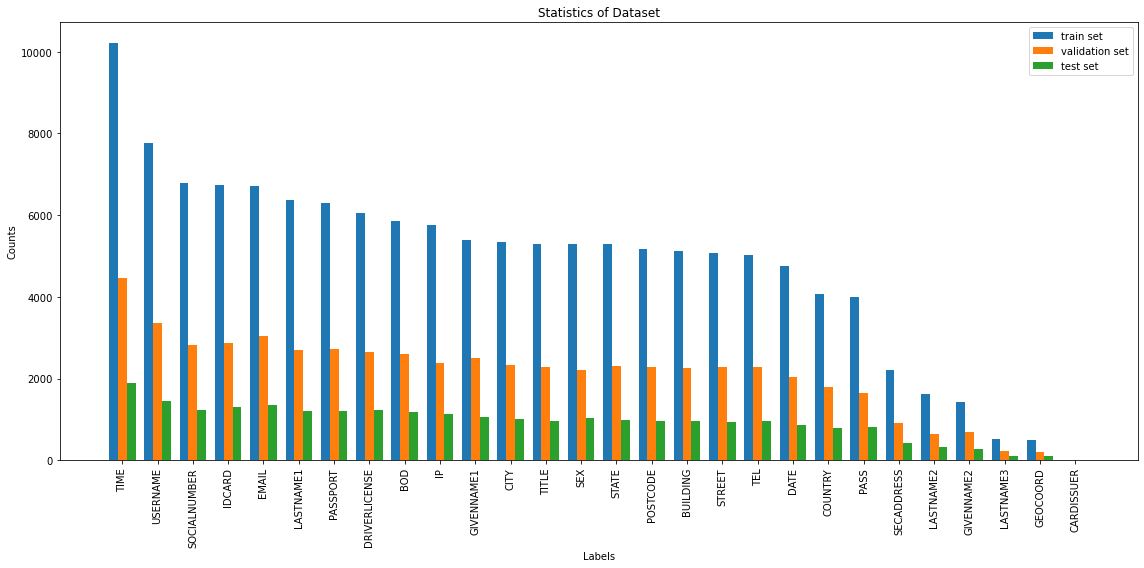

In [16]:
import matplotlib.pyplot as plt

# Sort keys by values in dict1
sorted_keys = sorted(train_label_counts, key=train_label_counts.get, reverse=True)

# Get values sorted according to sorted_keys
values1 = [train_label_counts[key] for key in sorted_keys]
values2 = [val_label_counts.get(key, 0) for key in sorted_keys]
values3 = [test_label_counts.get(key, 0) for key in sorted_keys]

# Create the plot
x = np.arange(len(sorted_keys))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - width, values1, width, label='train set')
rects2 = ax.bar(x, values2, width, label='validation set')
rects3 = ax.bar(x + width, values3, width, label='test set')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Labels')
ax.set_ylabel('Counts')
ax.set_title('Statistics of Dataset')
ax.set_xticks(x)
ax.set_xticklabels(sorted_keys, rotation=90)
ax.legend()

# Automatically adjust the subplot parameters to give some padding
fig.tight_layout()

plt.show()

In [17]:
sorted_keys

['TIME',
 'USERNAME',
 'SOCIALNUMBER',
 'IDCARD',
 'EMAIL',
 'LASTNAME1',
 'PASSPORT',
 'DRIVERLICENSE',
 'BOD',
 'IP',
 'GIVENNAME1',
 'CITY',
 'TITLE',
 'SEX',
 'STATE',
 'POSTCODE',
 'BUILDING',
 'STREET',
 'TEL',
 'DATE',
 'COUNTRY',
 'PASS',
 'SECADDRESS',
 'LASTNAME2',
 'GIVENNAME2',
 'LASTNAME3',
 'GEOCOORD',
 'CARDISSUER']

# testing the find_all_non_empty_masked_texts function

In [18]:
results = ["Identify and mask private identity information (PII) in the text.\n\n### Text:\nOn the video sharing platform for educational content, a lively discussion unfolded among users from different locales within the UK.\n\nThe comment thread began with paaltwvkjuijwbj957 expressing admiration for the video's insightful content, followed by 2005zheng.monckton adding a clarification on a complex topic. 43CU chimed in with a question for clarification, an\n\n### Masked text:\n\n### End of text.\n\n### Masked text:\nOn the video sharing platform for educational content, a lively discussion unfolded among users from different locales within the UK.\n\nThe comment thread began with [USERNAME] expressing admiration for the video's insightful content, followed by [USERNAME] adding a clarification on a complex topic. [USERNAME] chimed in with a question for clarification, an\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n\n### Masked text:\nOn the video sharing platform for educational content, a lively discussion unfolded among users from different locales within the UK.\n\nThe comment thread began with [USERNAME] expressing admiration for the video's insightful content, followed by [USERNAME] adding a clarification on a complex topic. [USERNAME] chimed in with a question for clarification, an\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n\n### Masked text:\nOn the video sharing platform for educational content, a lively discussion unfolded among users from different locales within the UK.\n\nThe comment thread began with [USERNAME] expressing admiration for the video's insightful content, followed by [USERNAME] adding a clarification on a complex topic. [USERNAME] chimed in with a question for clarification, an\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n\n### Masked text:\nOn the video sharing platform for educational content, a lively discussion unfolded among users from different locales within the UK.\n\nThe comment thread began with [USERNAME] expressing admiration for the video's insightful content, followed by [USERNAME] adding a clarification on a complex topic. [USERNAME] chimed in with a question for clarification, an\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n\n### Masked text:\nOn the video sharing platform for educational content, a lively discussion unfolded among users from different locales within the UK.\n\nThe comment thread began with [USERNAME] expressing admiration for the video's insightful content, followed by [USERNAME] adding a clarification on a complex topic. [USERNAME] chimed in with a question for clarification, an\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n\n### Masked text:\nOn the video sharing platform for educational content, a lively discussion unfolded among users from different locales within the UK.\n\nThe comment thread began with [USERNAME] expressing admiration for the video's insightful content, followed by [USERNAME] adding a clarification on a complex topic. [USERNAME] chimed in with a question for clarification, an\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n\n### Masked text:\nOn the video sharing platform for educational content, a lively discussion unfolded among users from different locales within the UK.\n\nThe comment thread began with [USERNAME] expressing admiration for the video's insightful content, followed by [USERNAME] adding a clarification on a complex topic. [USERNAME] chimed in with a question for clarification, an\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n\n### Masked text:\nOn the video sharing platform for educational content, a lively discussion unfolded among users from different locales within the UK.\n\nThe comment thread began with [USERNAME] expressing admiration for the video's insightful content, followed by [USERNAME] adding a clarification on a complex topic. [USERNAME] chimed in with a question for clarification, an\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n\n### Masked text:\nOn the video sharing platform for educational content, a lively discussion unfolded among users from different locales within the UK.\n\nThe comment thread began with [USERNAME] expressing admiration for the video's insightful content, followed by [USERNAME] adding a clarification on a complex topic. [USERNAME] chimed in with a question for clarification, an\n\n### End of text.\n\n### Masked text", "Identify and mask private identity information (PII) in the text.\n\n### Text:\nd wsfdkmi9214 shared personal experiences related to the video's theme.\n\nMeanwhile, lyxmvtinlajlq99997 and ylhhhrmivzz90 engaged in a friendly debate, each presenting well-supported arguments. maria-rosaria.amardi1962 shared a thought-provoking analogy, sparking further discussion among the users.\n\nThe conversation took a formal turn as 20jey.malov and D addressed e\n\n### Masked text:\n\n### End of text.\n\n### Masked text:\nd [USERNAME] shared personal experiences related to the video's theme.\n\nMeanwhile, [USERNAME] and [USERNAME] engaged in a friendly debate, each presenting well-supported arguments. [USERNAME] shared a thought-provoking analogy, sparking further discussion among the users.\n\nThe conversation took a formal turn as [USERNAME] and [USERNAME] addressed e\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n\n### Masked text:\nd [USERNAME] shared personal experiences related to the video's theme.\n\nMeanwhile, [USERNAME] and [USERNAME] engaged in a friendly debate, each presenting well-supported arguments. [USERNAME] shared a thought-provoking analogy, sparking further discussion among the users.\n\nThe conversation took a formal turn as [USERNAME] and [USERNAME] addressed e\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n\n### Masked text:\nd [USERNAME] shared personal experiences related to the video's theme.\n\nMeanwhile, [USERNAME] and [USERNAME] engaged in a friendly debate, each presenting well-supported arguments. [USERNAME] shared a thought-provoking analogy, sparking further discussion among the users.\n\nThe conversation took a formal turn as [USERNAME] and [USERNAME] addressed e\n\n### End of text.\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n\n### Masked text:\nd [USERNAME] shared personal experiences related to the video's theme.\n\nMeanwhile, [USERNAME] and [USERNAME] engaged in a friendly debate, each presenting well-supported arguments. [USERNAME] shared a thought-provoking analogy, sparking further discussion among the users.\n\nThe conversation took a formal turn as [USERNAME] and [USERNAME] addressed e\n\n### End of text.\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n\n### Masked text:\nd [USERNAME] shared personal experiences related to the video's theme.\n\nMeanwhile, [USERNAME] and [USERNAME] engaged in a friendly debate, each presenting well-supported arguments. [USERNAME] shared a thought-provoking analogy, sparking further discussion among the users.\n\nThe conversation took a formal turn as [USERNAME] and [USERNAME] addressed e\n\n### End of text.\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n\n### Masked text:\nd [USERNAME] shared personal experiences related to the video's theme.\n\nMeanwhile, [USERNAME] and [USERNAME] engaged in a friendly debate, each presenting well-supported arguments. [USERNAME] shared a thought-provoking analogy, sparking further discussion among the users.\n\nThe conversation took a formal turn as [USERNAME] and [USERNAME] addressed e\n\n### End of text.\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n\n### Masked text:\nd [USERNAME] shared personal experiences related to the video's theme.\n\nMeanwhile, [USERNAME] and [USERNAME] engaged in a friendly debate, each presenting well-supported arguments. [USERNAME] shared a thought-provoking analogy, sparking further discussion among the users.\n\nThe conversation took a formal turn as [USERNAME] and [USERNAME] addressed e\n\n### End of text.\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n\n### Masked text:\nd [USERNAME] shared personal experiences related to the video's theme.\n\nMeanwhile, [USERNAME] and [USERNAME] engaged in a friendly debate, each presenting well-supported arguments. [USERNAME] shared a thought-provoking analogy, sparking further discussion among the users.\n\nThe conversation took a formal turn as [USERNAME] and [USERNAME] addressed e\n\n### End of text.\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n", "Identify and mask private identity information (PII) in the text.\n\n### Text:\nach other respectfully in their comments. yeganeh-afchar and ylhhhrmivzz90 shared additional resources related to the video's topic, enriching the discussion further.\n\nThroughout the interaction, the diverse perspectives and insights shared by individuals added depth and richness to the educational dialogue on the platform.\n\nBACKGROUND: 22:41 on December 21st, 1966\n\n### Masked text:\n\n### End of text.\n\n### Masked text:\nBACKGROUND: [TIME] on [DATE]\n\n### End of text.\n\n### Masked text:\nBACKGROUND: [TIME] on [DATE]\n\n### End of text.\n\n### Masked text:\nBACKGROUND: [TIME] on [DATE]\n\n### End of text.\n\n### Masked text:\nBACKGROUND: [TIME] on [DATE]\n\n### End of text.\n\n### Masked text:\nBACKGROUND: [TIME] on [DATE]\n\n### End of text.\n\n### Masked text:\nBACKGROUND: [TIME] on [DATE]\n\n### End of text.\n\n### Masked text:\nBACKGROUND: [TIME] on [DATE]\n\n### End of text.\n\n### Masked text:\nBACKGROUND: [TIME] on [DATE]\n\n### End of text.\n\n### Masked text:\nBACKGROUND: [TIME] on [DATE]\n\n### End of text.\n\n### Masked text:\nBACKGROUND: [TIME] on [DATE]\n\n### End of text.\n\n### Masked text:\nBACKGROUND: [TIME] on [DATE]\n\n### End of text.\n\n### Masked text:\nBACKGROUND: [TIME] on [DATE]\n\n### End of text.\n\n### Masked text:\nBACKGROUND: [TIME] on [DATE]\n\n### End of text.\n\n### Masked text:\nBACKGROUND: [TIME] on [DATE]\n\n### End of text.\n\n### Masked text:\nBACKGROUND: [TIME] on [DATE]\n\n### End of text.\n\n### Masked text:\nBACKGROUND: [TIME] on [DATE]\n\n### End of text.\n\n### Masked text:\nBACKGROUND: [TIME] on [DATE]\n\n### End of text.\n\n### Masked text:\nBACKGROUND: [TIME] on [DATE]\n\n### End of text.\n\n### Masked text:\nBACKGROUND: [TIME] on [DATE]\n\n### End of text.\n\n### Masked text:\nBACKGROUND: [TIME] on [DATE]\n\n### End of text.\n\n### Masked text:\nBACKGROUND: [TIME] on [DATE]\n\n### End of text.\n\n### Masked text:\nBACKGROUND: [TIME] on [DATE]\n\n### End of text.\n\n### Masked text:\nBACKGROUND: [TIME] on [DATE]\n\n### End of text.\n\n### Masked text:\nBACKGROUND: [TIME] on [DATE]\n\n### End of text.\n\n### Masked text:\nBACKGROUND: [TIME] on [DATE]\n\n### End of text.\n\n### Masked text:\nBACKGROUND: [TIME] on [DATE]\n\n### End of text.\n\n### Masked text:\nBACKGROUND: [TIME] on [DATE]\n\n### End of text.\n\n### Masked text:\nBACKGROUND: [TIME] on [DATE]\n\n### End of text.\n\n### Masked text:\nBACKGROUND: [TIME] on [DATE]\n\n### End of text.\n\n### Masked text:\nBACKGROUND: [TIME] on [DATE]\n\n### End of text.\n\n### Masked text:\nBACKGROUND: [TIME] on [DATE]\n\n### End of text.\n\n### Masked text:\nBACKGROUND: [TIME] on [DATE]\n\n### End of text.\n\n### Masked text:\nBACKGROUND: [TIME] on [DATE]\n\n", 'Identify and mask private identity information (PII) in the text.\n\n### Text:\n{\n  "Guidelines": {\n    "maximumAge": "May 5th, 1966",\n    "minimumAge": "17th February 1946",\n    "acceptableFormat": "January/88",\n    "additionalRequirements": "1977-04-07T00:00:00",\n    "exceptionCases": "October 18th, 1980"\n  },\n  "Regulations": {\n    "verificationProcess": "YJ70705OQ",\n    "submissionDeadline": "QX41041CO",\n    "reviewPeriod": "HZ70769AY",\n    "interviewSchedule": "HI64277IW",\n    "decisionNotification": "SU2014976"\n  }\n}\n\n### Masked text:\n\n### End of text.\n\n### Masked text:\n{\n  "Guidelines": {\n    "maximumAge": "[BOD]",\n    "minimumAge": "[BOD]",\n    "acceptableFormat": "[BOD]",\n    "additionalRequirements": "[BOD]",\n    "exceptionCases": "[BOD]"\n  },\n  "Regulations": {\n    "verificationProcess": "[IDCARD]",\n    "submissionDeadline": "[IDCARD]",\n    "reviewPeriod": "[IDCARD]",\n    "interviewSchedule": "[IDCARD]",\n    "decisionNotification": "[IDCARD]"\n  }\n}\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n\n### Masked text:\n{\n  "Guidelines": {\n    "maximumAge": "[BOD]",\n    "minimumAge": "[BOD]",\n    "acceptableFormat": "[BOD]",\n    "additionalRequirements": "[BOD]",\n    "exceptionCases": "[BOD]"\n  },\n  "Regulations": {\n    "verificationProcess": "[IDCARD]",\n    "submissionDeadline": "[IDCARD]",\n    "reviewPeriod": "[IDCARD]",\n    "interviewSchedule": "[IDCARD]",\n    "decisionNotification": "[IDCARD]"\n  }\n}\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n\n### Masked text:\n{\n  "Guidelines": {\n    "maximumAge": "[BOD]",\n    "minimumAge": "[BOD]",\n    "acceptableFormat": "[BOD]",\n    "additionalRequirements": "[BOD]",\n    "exceptionCases": "[BOD]"\n  },\n  "Regulations": {\n    "verificationProcess": "[IDCARD]",\n    "submissionDeadline": "[IDCARD]",\n    "reviewPeriod": "[IDCARD]",\n    "interviewSchedule": "[IDCARD]",\n    "decisionNotification": "[IDCARD]"\n  }\n}\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n\n### Masked text:\n{\n  "Guidelines": {\n    "maximumAge": "[BOD]",\n    "minimumAge": "[BOD]",\n    "acceptableFormat": "[BOD]",\n    "additionalRequirements": "[BOD]",\n    "exceptionCases": "[BOD]"\n  },\n  "Regulations": {\n    "verificationProcess": "[IDCARD]",\n    "submissionDeadline": "[IDCARD]",\n    "reviewPeriod": "[IDCARD]",\n    "interviewSchedule": "[IDCARD]",\n    "decisionNotification": "[IDCARD]"\n  }\n}\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n\n### Masked text:\n{\n  "Guidelines": {\n    "maximumAge": "[BOD]",\n    "minimumAge": "[BOD]",\n    "acceptableFormat": "[BOD]",\n    "additionalRequirements": "[BOD]",\n    "exceptionCases": "[BOD]"\n  },\n  "Regulations": {\n    "verificationProcess": "[IDCARD]",\n    "submissionDeadline": "[IDCARD]",\n    "reviewPeriod": "[IDCARD]",\n    "interviewSchedule": "[IDCARD]",\n    "decisionNotification": "[IDCARD]"\n  }\n}\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n\n### Masked text:\n{\n  "Guidelines": {\n    "maximumAge": "[BOD]",\n    "minimumAge": "[BOD]",\n    "acceptableFormat": "[BOD]",\n    "additionalRequirements": "[BOD]",\n    "exceptionCases": "[BOD]"\n  },\n  "Reg', "Identify and mask private identity information (PII) in the text.\n\n### Text:\nSubject: Collaboration Opportunity in Online Course Development\n\nDear Team,\n\nI hope this email finds you well. I am writing to propose a collaboration opportunity for the development of our upcoming online course. With your expertise and dedication to excellence, I believe we can create a truly enriching learning experience.\n\nLet's introduce the team members involved in this exciting proj\n\n### Masked text:\n\nSubject: Collaboration Opportunity in Online Course Development\n\nDear Team,\n\nI hope this email finds you well. I am writing to propose a collaboration opportunity for the development of our upcoming online course. With your expertise and dedication to excellence, I believe we can create a truly enriching learning experience.\n\nLet's introduce the team members involved in this exciting proj\n\n### End of text.\n\n### Masked text:\n\nSubject: Collaboration Opportunity in Online Course Development\n\nDear Team,\n\nI hope this email finds you well. I am writing to propose a collaboration opportunity for the development of our upcoming online course. With your expertise and dedication to excellence, I believe we can create a truly enriching learning experience.\n\nLet's introduce the team members involved in this exciting proj\n\n### End of text.\n\n### End of masked text.\n\n### End of text.\n\n### Masked text:\nSubject: Collaboration Opportunity in Online Course Development\n\nDear Team,\n\nI hope this email finds you well. I am writing to propose a collaboration opportunity for the development of our upcoming online course. With your expertise and dedication to excellence, I believe we can create a truly enriching learning experience.\n\nLet's introduce the team members involved in this exciting proj\n\n### End of text.\n\n### End of masked text.\n\n### End of text.\n\n### Masked text:\nSubject: Collaboration Opportunity in Online Course Development\n\nDear Team,\n\nI hope this email finds you well. I am writing to propose a collaboration opportunity for the development of our upcoming online course. With your expertise and dedication to excellence, I believe we can create a truly enriching learning experience.\n\nLet's introduce the team members involved in this exciting proj\n\n### End of text.\n\n### End of masked text.\n\n### End of text.\n\n### Masked text:\nSubject: Collaboration Opportunity in Online Course Development\n\nDear Team,\n\nI hope this email finds you well. I am writing to propose a collaboration opportunity for the development of our upcoming online course. With your expertise and dedication to excellence, I believe we can create a truly enriching learning experience.\n\nLet's introduce the team members involved in this exciting proj\n\n### End of text.\n\n### End of masked text.\n\n### End of text.\n\n### Masked text:\nSubject: Collaboration Opportunity in Online Course Development\n\nDear Team,\n\nI hope this email finds you well. I am writing to propose a collaboration opportunity for the development of our upcoming online course. With your expertise and dedication to excellence, I believe we can create a truly enriching learning experience.\n\nLet's introduce the team members involved in this exciting proj\n\n### End of text.\n\n### End of masked text.\n\n### End of text.\n\n### Masked text:\nSubject: Collaboration Opportunity in Online Course Development\n\nDear Team,\n\nI hope this email finds you well. I am writing to propose a collaboration opportunity for the development of our upcoming online course. With your expertise and dedication to excellence, I believe we can create a truly enriching learning experience.\n\nLet's introduce the team members involved in this exciting proj\n\n### End of text.\n\n### End of masked text.\n\n### End of text.\n\n### Masked text:\nSubject: Collaboration Opportunity in Online Course Development\n\nDear Team,\n\nI hope this email finds you well. I am writing to propose a collaboration opportunity for the development of our upcoming online course. With your expertise and dedication to excellence, I believe we can create a truly enriching learning experience.\n\nLet's introduce the team members involved in this exciting proj\n\n### End of text.\n\n### End of masked text.\n\n### End of text.\n\n### Masked text:\nSubject: Collaboration Opportunity in Online Course Development\n\nDear Team,\n\nI hope this email finds you well. I am writing to propose a collaboration opportunity for the development of our upcoming online course. With your expertise and dedication to excell", 'Identify and mask private identity information (PII) in the text.\n\n### Text:\nect:\n\n1. M\n   - 0090106547\n   \n2. F\n   - CHAVA.358139.CA.411\n   \n3. M\n   - AUSTI 711154 AS 852\n   \n4. F\n   - THRES.862083.9.697\n   \n5. O\n   - PIEN9.703185.PL.492\n   \n6. Prefer not to disclose\n   - JESUT6020279210\n\nThe combined expertise and diverse perspectives of our team will undoubtedly elevate the quality of our online course. Our goal is to provide students with a dynamic and engagin\n\n### Masked text:\n\n1. [SEX]\n   - [DRIVERLICENSE]\n   \n2. [SEX]\n   - [DRIVERLICENSE]\n   \n3. [SEX]\n   - [DRIVERLICENSE]\n   \n4. [SEX]\n   - [DRIVERLICENSE]\n   \n5. [SEX]\n   - [DRIVERLICENSE]\n   \n6. [SEX]\n   - [DRIVERLICENSE]\n\nThe combined expertise and diverse perspectives of our team will undoubtedly elevate the quality of our online course. Our goal is to provide students with a dynamic and engagin\n\n### End of text.\n\n### Masked text:\n\n1. [SEX]\n   - [DRIVERLICENSE]\n   \n2. [SEX]\n   - [DRIVERLICENSE]\n   \n3. [SEX]\n   - [DRIVERLICENSE]\n   \n4. [SEX]\n   - [DRIVERLICENSE]\n   \n5. [SEX]\n   - [DRIVERLICENSE]\n   \n6. [SEX]\n   - [DRIVERLICENSE]\n\nThe combined expertise and diverse perspectives of our team will undoubtedly elevate the quality of our online course. Our goal is to provide students with a dynamic and engagin\n\n### End of text.\n\n### End of masked text.\n\n### End of text.\n\n### Masked text:\n\n1. [SEX]\n   - [DRIVERLICENSE]\n   \n2. [SEX]\n   - [DRIVERLICENSE]\n   \n3. [SEX]\n   - [DRIVERLICENSE]\n   \n4. [SEX]\n   - [DRIVERLICENSE]\n   \n5. [SEX]\n   - [DRIVERLICENSE]\n   \n6. [SEX]\n   - [DRIVERLICENSE]\n\nThe combined expertise and diverse perspectives of our team will undoubtedly elevate the quality of our online course. Our goal is to provide students with a dynamic and engagin\n\n### End of text.\n\n### End of masked text.\n\n### End of text.\n\n### Masked text:\n\n1. [SEX]\n   - [DRIVERLICENSE]\n   \n2. [SEX]\n   - [DRIVERLICENSE]\n   \n3. [SEX]\n   - [DRIVERLICENSE]\n   \n4. [SEX]\n   - [DRIVERLICENSE]\n   \n5. [SEX]\n   - [DRIVERLICENSE]\n   \n6. [SEX]\n   - [DRIVERLICENSE]\n\nThe combined expertise and diverse perspectives of our team will undoubtedly elevate the quality of our online course. Our goal is to provide students with a dynamic and engagin\n\n### End of text.\n\n### End of masked text.\n\n### End of text.\n\n### Masked text:\n\n1. [SEX]\n   - [DRIVERLICENSE]\n   \n2. [SEX]\n   - [DRIVERLICENSE]\n   \n3. [SEX]\n   - [DRIVERLICENSE]\n   \n4. [SEX]\n   - [DRIVERLICENSE]\n   \n5. [SEX]\n   - [DRIVERLICENSE]\n   \n6. [SEX]\n   - [DRIVERLICENSE]\n\nThe combined expertise and diverse perspectives of our team will undoubtedly elevate the quality of our online course. Our goal is to provide students with a dynamic and engagin\n\n### End of text.\n\n### End of masked text.\n\n### End of text.\n\n### Masked text:\n\n1. [SEX]\n   - [DRIVERLICENSE]\n   \n2. [SEX]\n   - [DRIVERLICENSE]\n   \n3. [SEX]\n   - [DRIVERLICENSE]\n   \n4. [SEX]\n   - [D', 'Identify and mask private identity information (PII) in the text.\n\n### Text:\ng learning environment that fosters growth and development.\n\nWe are planning to kick off this project at 17 on January/47 at our office located on Montague Road. Please confirm your availability for the meeting so we can discuss further details and set our course of action.\n\nLooking forward to a fruitful collaboration ahead.\n\nBest regards,\n\n[Your Name]\n[Your Position]\n[Your Institution]\n\n### Masked text:\n\n### End of text.\n\n### Text:\ng learning environment that fosters growth and development.\n\nWe are planning to kick off this project at [TIME] on [DATE] at our office located on [STREET]. Please confirm your availability for the meeting so we can discuss further details and set our course of action.\n\nLooking forward to a fruitful collaboration ahead.\n\nBest regards,\n\n[Your Name]\n[Your Position]\n[Your Institution]\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n\n### Text:\ng learning environment that fosters growth and development.\n\nWe are planning to kick off this project at [TIME] on [DATE] at our office located on [STREET]. Please confirm your availability for the meeting so we can discuss further details and set our course of action.\n\nLooking forward to a fruitful collaboration ahead.\n\nBest regards,\n\n[Your Name]\n[Your Position]\n[Your Institution]\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n\n### Text:\ng learning environment that fosters growth and development.\n\nWe are planning to kick off this project at [TIME] on [DATE] at our office located on [STREET]. Please confirm your availability for the meeting so we can discuss further details and set our course of action.\n\nLooking forward to a fruitful collaboration ahead.\n\nBest regards,\n\n[Your Name]\n[Your Position]\n[Your Institution]\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n\n### Text:\ng learning environment that fosters growth and development.\n\nWe are planning to kick off this project at [TIME] on [DATE] at our office located on [STREET]. Please confirm your availability for the meeting so we can discuss further details and set our course of action.\n\nLooking forward to a fruitful collaboration ahead.\n\nBest regards,\n\n[Your Name]\n[Your Position]\n[Your Institution]\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n\n### Text:\ng learning environment that fosters growth and development.\n\nWe are planning to kick off this project at [TIME] on [DATE] at our office located on [STREET]. Please confirm your availability for the meeting so we can discuss further details and set our course of action.\n\nLooking forward to a fruitful collaboration ahead.\n\nBest regards,\n\n[Your Name]\n[Your Position]\n[Your Institution]\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n\n### Text:\ng learning environment that fosters growth and development.\n\nWe are planning to kick off this project at [TIME] on [DATE] at our office located on [STREET]. Please confirm your availability for the meeting so we can discuss further details and set our course of action.\n\nLooking forward to a fruitful collaboration ahead.\n\nBest regards,\n\n[Your Name]\n[Your Position]\n[Your Institution]\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n\n### Text:\ng learning environment that fosters growth and development.\n\nWe are planning to kick off this project at [TIME] on [DATE] at our office located on [STREET]. Please confirm your availability for the meeting so we can discuss further details and set our course of action.\n\nLooking forward to a fruitful collaboration ahead.\n\nBest regards,\n\n[Your Name]\n[Your Position]\n[Your Institution]\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n\n### Text:\ng learning environment that fosters growth and development.\n\nWe are planning to kick off this project at [TIME] on [DATE] at our office located on [STREET]. Please confirm your availability for the meeting so we can discuss further details and set our course of action.\n\nLooking forward to a fruitful collaboration ahead.\n\nBest regards,\n\n[Your Name]\n[Your Position]\n[Your Institution]\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n\n### Text:\ng learning environment that fosters growth and development.\n\nWe are planning to kick off', 'Identify and mask private identity information (PII) in the text.\n\n### Text:\n{\n\t"participants": [{\n\t\t\t"participant_id": "HR37827HB",\n\t\t\t"gender": "Female",\n\t\t\t"username": "1942lili-anne.poppke",\n\t\t\t"personal_info": {\n\t\t\t\t"given_name": "Lili-Anne",\n\t\t\t\t"last_name": "Poppke",\n\t\t\t\t"country": "United Kingdom",\n\t\t\t\t"building": "617",\n\t\t\t\t"street": "Holme Wood Lane",\n\t\t\t\t"city": "Doncaster",\n\t\t\t\t"state": "ENG",\n\t\t\t\t"postcode": "DN3 3EH, DN3 3EQ"\n\t\t\t},\n\t\t\t"time": "13:54",\n\t\t\t"additional_info"\n\n### Masked text:\n{\n\t"participants": [{\n\t\t\t"participant_id": "[IDCARD]",\n\t\t\t"gender": "[SEX]",\n\t\t\t"username": "[USERNAME]",\n\t\t\t"personal_info": {\n\t\t\t\t"given_name": "[GIVENNAME1]",\n\t\t\t\t"last_name": "[LASTNAME1]",\n\t\t\t\t"country": "[COUNTRY]",\n\t\t\t\t"building": "[BUILDING]",\n\t\t\t\t"street": "[STREET]",\n\t\t\t\t"city": "[CITY]",\n\t\t\t\t"state": "[STATE]",\n\t\t\t\t"postcode": "[POSTCODE]"\n\t\t\t},\n\t\t\t"time": "[TIME]",\n\t\t\t"additional_info"\n\n### End of masked text.\n\n### End of text.\n\n### Postal Code: 92035-2003\n\n### Date: 19/09/2019\n\n### Time: 11:25 AM\n\n### Geographical Coordinates: [38.5, -120.5]\n\n### Date: 19/09/2019\n\n### Time: 11:25 AM\n\n### Geographical Coordinates: [38.5, -120.5]\n\n### End of postcode.\n\n### End of text.\n\n### Postal Code: 92035-2003\n\n### Date: 19/09/2019\n\n### Time: 11:25 AM\n\n### Geographical Coordinates: [38.5, -120.5]\n\n### Date: 19/09/2019\n\n### Time: 11:25 AM\n\n### Geographical Coordinates: [38.5, -120.5]\n\n### End of postcode.\n\n### End of text.\n\n### Postal Code: 92035-2003\n\n### Date: 19/09/2019\n\n### Time: 11:25 AM\n\n### Geographical Coordinates: [38.5, -120.5]\n\n### Date: 19/09/2019\n\n### Time: 11:25 AM\n\n### Geographical Coordinates: [38.5, -120.5]\n\n### End of postcode.\n\n### End of text.\n\n### Postal Code: 92035-2003\n\n### Date: 19/09/2019\n\n### Time: 11:25 AM\n\n### Geographical Coordinates: [38.5, -120.5]\n\n### Date: 19/09/2019\n\n### Time: 11:25 AM\n\n### Geographical Coordinates: [38.5, -120.5]\n\n### End of postcode.\n\n### End of text.\n\n### Postal Code: 92035-2003\n\n### Date: 19/09/2019\n\n### Time: 11:25 AM\n\n### Geographical Coordinates: [38.5, -120.5]\n\n### Date: 19/09/2019\n\n### Time: 11:25 AM\n\n### Geographical Coordinates: [38.5, -120.5]\n\n### End of postcode.\n\n### End of text.\n\n### Postal Code: 92035-2003\n\n### Date: 19/09/2019\n\n### Time: 11:25 AM\n\n### Geographical Coordinates: [38.5, -120.5]\n\n### Date: 19/09/2019\n\n### Time: 11:25 AM\n']

In [19]:
len(results)

8

In [20]:
find_all_non_empty_masked_texts(results[0])

"\nOn the video sharing platform for educational content, a lively discussion unfolded among users from different locales within the UK.\n\nThe comment thread began with [USERNAME] expressing admiration for the video's insightful content, followed by [USERNAME] adding a clarification on a complex topic. [USERNAME] chimed in with a question for clarification, an\n\n"

# Analysis on the llama 2 7b results with old labels

In [21]:
df = pd.read_csv("pii-masking-300k-llama2-sft/test_pii_english_llama2_7b_sft_output.csv")

In [22]:
df['parsed output'] = df['llama2_response'].apply(find_all_non_empty_masked_texts)

In [32]:
#df.to_csv('parsed_test_pii_english_llama2_7b_sft_output.csv')

In [23]:
df['parsed output'][4]

''

In [24]:
df['llama2_response'][4]

"Identify and mask private identity information (PII) in the text.\n\n### Text:\n143\n   - Time of Access: 6 PM\n\n8. Driver H:\n   - Driver's License: AGNÉ9709278AF614\n   - Time of Access: 01\n\n9. Driver I:\n   - Driver's License: JERON 909065 9 841\n   - Time of Access: 22 o'clock\n\nWe value your participation in promoting legal digital rights and freedom of expression. Your dedication to these principles will help shape a more inclusive and respectful online environment for all.\n\nThank you for being a part of our mission.\n\nWarm regards,\n[Legal Platform Name]\n\n### Masked text:\n\n### End of text.\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n\n### End of text.\n\n### Masked text:\n\n### End of text.\n\n### End of text.\n\n#

In [25]:
df

,source_text,target_text,privacy_mask,span_labels,mbert_text_tokens,mbert_bio_labels,id,language,set,llama2_response,parsed output
0,**Guest Injury Report**\n\n**Date:** 14/11/200...,**Guest Injury Report**\n\n**Date:** [DATE]\n\...,"[{'value': '14/11/2008', 'start': 35, 'end': 4...","[[269, 273, ""TIME""], [237, 247, ""PASS""], [181,...","['*', '*', 'Guest', 'In', '##jur', '##y', 'Rep...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...",51430A,English,validation,Identify and mask private identity information...,\n**Guest Injury Report**\n\n**Date:** [DATE]\...
1,"ions for improvement.\n\nDear 1947octavius,\n\...","ions for improvement.\n\nDear [USERNAME],\n\nI...","[{'value': '1947octavius', 'start': 28, 'end':...","[[259, 267, ""TIME""], [200, 214, ""IDCARD""], [28...","['ions', 'for', 'improvement', '.', 'Dear', '1...","['O', 'O', 'O', 'O', 'O', 'B-USERNAME', 'I-USE...",42870C,English,validation,Identify and mask private identity information...,"\nions for improvement.\n\nDear [USERNAME],\n\..."
2,"""ECD Enrollment Form \n\nChild Information:\n\...","""ECD Enrollment Form \n\nChild Information:\n\...","[{'value': 'Fichtner', 'start': 60, 'end': 68,...","[[317, 329, ""SOCIALNUMBER""], [274, 290, ""USERN...","['""', 'EC', '##D', 'En', '##roll', '##ment', '...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...",43198A,English,validation,Identify and mask private identity information...,\n\nChild Information:\n\nChild 1:\n- Name: [L...
3,leardo\n - **Sex:** Masculine\n - **Emai...,leardo\n - **Sex:** [SEX]\n - **Email:**...,"[{'value': 'Masculine', 'start': 22, 'end': 31...","[[439, 444, ""SEX""], [416, 423, ""GIVENNAME1""], ...","['lea', '##rdo', '-', '*', '*', 'Sex', ':', '*...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...",48448D,English,validation,Identify and mask private identity information...,\nleardo\n - **Sex:** [SEX]\n - **Email:...
4,143\n - Time of Access: 6 PM\n\n8. Driver H:...,143\n - Time of Access: [TIME]\n\n8. Driver ...,"[{'value': '6 PM', 'start': 25, 'end': 29, 'la...","[[185, 195, ""TIME""], [145, 163, ""DRIVERLICENSE...","['143', '-', 'Time', 'of', 'Access', ':', '6',...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-TI...",44335C,English,validation,Identify and mask private identity information...,
...,...,...,...,...,...,...,...,...,...,...,...
3968,r_license>MEDA9.655199.9.875</driver_license>\...,r_license>[DRIVERLICENSE]</driver_license>\n ...,"[{'value': 'MEDA9.655199.9.875', 'start': 10, ...","[[375, 391, ""GEOCOORD""], [240, 244, ""GIVENNAME...","['r', '_', 'license', '>', 'ME', '##DA', '##9'...","['O', 'O', 'O', 'O', 'B-DRIVERLICENSE', 'I-DRI...",46618C,English,validation,Identify and mask private identity information...,\nr_license>[DRIVERLICENSE]</driver_license>\n...
3969,ace 256\n Password: '9Az\n\nPlease review th...,ace 256\n Password: [PASS]\n\nPlease review ...,"[{'value': ""'9Az"", 'start': 21, 'end': 25, 'la...","[[21, 25, ""PASS""]]","['ac', '##e', '256', 'Pass', '##word', ':', ""'...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...",51953C,English,validation,Identify and mask private identity information...,
3970,"De Sapio], hereby consent to the asthma and a...","[LASTNAME2]], hereby consent to the asthma an...","[{'value': 'De Sapio', 'start': 1, 'end': 9, '...","[[369, 379, ""BOD""], [350, 357, ""LASTNAME1""], [...","['De', 'Sa', '##pio', ']', ',', 'here', '##by'...","['B-LASTNAME2', 'I-LASTNAME2', 'I-LASTNAME2', ...",49747B,English,validation,Identify and mask private identity information...,"\n [LASTNAME1]], hereby consent to the asthma ..."
3971,towards a fulfilling career path.\n\n**Spotlig...,towards a fulfilling career path.\n\n**Spotlig...,"[{'value': 'Jozef', 'start': 131, 'end': 136, ...","[[399, 407, ""LASTNAME1""], [394, 398, ""GIVENNAM...","['towards', 'a', 'fu', '##lf', '##illing', 'ca...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...",41212B,English,validation,Identify and mask private identity information...,\ntowards a fulfilling career path.\n\n**

In [26]:
df.loc[df['parsed output'] == ""]

,source_text,target_text,privacy_mask,span_labels,mbert_text_tokens,mbert_bio_labels,id,language,set,llama2_response,parsed output
4,143\n - Time of Access: 6 PM\n\n8. Driver H:...,143\n - Time of Access: [TIME]\n\n8. Driver ...,"[{'value': '6 PM', 'start': 25, 'end': 29, 'la...","[[185, 195, ""TIME""], [145, 163, ""DRIVERLICENSE...","['143', '-', 'Time', 'of', 'Access', ':', '6',...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-TI...",44335C,English,validation,Identify and mask private identity information...,
18,ent's health information is as follows:\n\n- D...,ent's health information is as follows:\n\n- D...,"[{'value': '30th August 1937', 'start': 59, 'e...","[[90, 96, ""USERNAME""], [59, 75, ""BOD""]]","['ent', ""'"", 's', 'health', 'information', 'is...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...",49003B,English,validation,Identify and mask private identity information...,
20,nriching our interactions and fostering a sens...,nriching our interactions and fostering a sens...,"[{'value': '12/06/2049', 'start': 150, 'end': ...","[[191, 193, ""STATE""], [164, 174, ""TIME""], [150...","['nr', '##ichi', '##ng', 'our', 'interactions'...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...",51159D,English,validation,Identify and mask private identity information...,
30,n3048@outlook.com: Can you provide details abo...,n3048@outlook.com: Can you provide details abo...,"[{'value': 'flamackeprang1975@tutanota.com', '...","[[388, 406, ""GEOCOORD""], [120, 150, ""EMAIL""]]","['n', '##30', '##48', '@', 'out', '##lo', '##o...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...",43111C,English,validation,Identify and mask private identity information...,
34,"ST, NE4 5SU, NE4 5TH\n \n...and continue the ...","ST, NE4 5SU, NE4 5TH\n \n...and continue the ...",[],[],"['ST', ',', 'NE', '##4', '5', '##SU', ',', 'NE...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...",42736C,English,validation,Identify and mask private identity information...,
...,...,...,...,...,...,...,...,...,...,...,...
3959,"ocated your file. Now, could you verify your F...","ocated your file. Now, could you verify your [...","[{'value': 'F', 'start': 45, 'end': 46, 'label...","[[271, 272, ""SEX""], [265, 266, ""SEX""], [210, 2...","['oca', '##ted', 'your', 'file', '.', 'Now', '...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...",49401B,English,validation,Identify and mask private identity information...,
3961,"ollow the prescribed treatment plans, take med...","ollow the prescribed treatment plans, take med...","[{'value': '1:52 AM', 'start': 302, 'end': 309...","[[302, 309, ""DATE""]]","['ol', '##low', 'the', 'pre', '##sc', '##rib',...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...",43004C,English,validation,Identify and mask private identity information...,
3967,</Participant>\n <Participant>\n <Pass...,</Participant>\n <Participant>\n <Pass...,"[{'value': '921949896', 'start': 49, 'end': 58...","[[409, 418, ""PASSPORT""], [337, 346, ""PASSPORT""...","['<', '/', 'Parti', '##ci', '##pan', '##t', '>...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...",41363D,English,validation,Identify and mask private identity information...,
3969,ace 256\n Password: '9Az\n\nPlease review th...,ace 256\n Password: [PASS]\n\nPlease review ...,"[{'value': ""'9Az"", 'start': 21, 'end': 25, 'la...","[[21, 25, ""PASS""]]","['ac', '##e', '256', 'Pass', '##word', ':', ""'...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...",51953C,English,validation,Identify and mask private identity information...,


In [27]:
df_temp = df.loc[df['parsed output'] != ""]

In [30]:
mistakes = []
marker_categories = ['TIME',
 'USERNAME',
 'SOCIALNUMBER',
 'IDCARD',
 'EMAIL',
 'LASTNAME1',
 'PASSPORT',
 'DRIVERLICENSE',
 'BOD',
 'IP',
 'GIVENNAME1',
 'CITY',
 'TITLE',
 'SEX',
 'STATE',
 'POSTCODE',
 'BUILDING',
 'STREET',
 'TEL',
 'DATE',
 'COUNTRY',
 'PASS',
 'SECADDRESS',
 'LASTNAME2',
 'GIVENNAME2',
 'LASTNAME3',
 'GEOCOORD',
 'CARDISSUER']

metrics = {marker: {'TP': 0, 'FP': 0, 'FN': 0} for marker in marker_categories}

for input_sentence, ground_truth, model_output in zip(df_temp['source_text'], df_temp['target_text'], df_temp['parsed output']):
    for marker in marker_categories:
        # Check if the marker exists in ground truth and model output
        ground_truth_contains = ground_truth.count(f'[{marker}]')
        model_output_contains = model_output.count(f'[{marker}]')
        
        if model_output_contains == ground_truth_contains:
            metrics[marker]['TP'] += ground_truth_contains
        elif model_output_contains > ground_truth_contains:
            metrics[marker]['TP'] += ground_truth_contains
            metrics[marker]['FP'] = metrics[marker]['FP'] + (model_output_contains - ground_truth_contains)
            mistakes.append([input_sentence, ground_truth, model_output])
        else:
            metrics[marker]['TP'] += model_output_contains
            metrics[marker]['FN'] = metrics[marker]['FP'] + (ground_truth_contains - model_output_contains)
            mistakes.append([input_sentence, ground_truth, model_output])
        
        """
        if ground_truth_contains and model_output_contains:
            metrics[marker]['TP'] += 1
        elif ground_truth_contains and not model_output_contains:
            metrics[marker]['FN'] += 1
        elif not ground_truth_contains and model_output_contains:
            metrics[marker]['FP'] += 1
        """
        
results = {}
for marker, counts in metrics.items():
    TP = counts['TP']
    FP = counts['FP']
    FN = counts['FN']
    
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    
    results[marker] = {
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score
    }


In [31]:
import pandas as pd

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results).transpose()
print(results_df)

               Precision    Recall  F1-Score
TIME            0.962485  0.960712  0.961598
USERNAME        0.950715  0.950715  0.950715
SOCIALNUMBER    0.918047  0.919651  0.918848
IDCARD          0.962371  0.961466  0.961918
EMAIL           0.981651  0.981651  0.981651
LASTNAME1       0.893116  0.895550  0.894331
PASSPORT        0.884211  0.884987  0.884599
DRIVERLICENSE   0.950192  0.949282  0.949737
BOD             0.949634  0.950504  0.950069
IP              0.980806  0.984586  0.982692
GIVENNAME1      0.859756  0.858883  0.859319
CITY            0.965255  0.965255  0.965255
TITLE           0.951381  0.950331  0.950856
SEX             0.939459  0.938445  0.938952
STATE           0.961883  0.965129  0.963504
POSTCODE        0.959397  0.958285  0.958841
BUILDING        0.970421  0.971526  0.970973
STREET          0.963134  0.963134  0.963134
TEL             0.961982  0.960875  0.961428
DATE            0.941606  0.941606  0.941606
COUNTRY         0.951807  0.949266  0.950535
PASS      

In [35]:
mistakes_df = pd.DataFrame(mistakes, columns=['Input', 'Groundtruth', 'Output'])

In [36]:
mistakes_df

,Input,Groundtruth,Output
0,tted: 3:19am\n\n#### Part 3 - Reason for Exemp...,tted: [TIME]\n\n#### Part 3 - Reason for Exemp...,\n\n#### Part 3 - Reason for Exemption\nPlease...
1,Subject: Innovative Conflict Resolution Strate...,Subject: Innovative Conflict Resolution Strate...,\n\nSubject: Innovative Conflict Resolution St...
2,LASTNAME1 | COMMENT\n1 | P65@aol.com ...,LASTNAME1 | COMMENT\n1 | [EMAIL] ...,\nLASTNAME1 | COMMENT\n1 | [EMAIL] ...
3,LASTNAME1 | COMMENT\n1 | P65@aol.com ...,LASTNAME1 | COMMENT\n1 | [EMAIL] ...,\nLASTNAME1 | COMMENT\n1 | [EMAIL] ...
4,"""Engage in active listening and...","""Engage in active listening and...","\n ""Engage in active listening a..."
...,...,...,...
1712,<Child_Protection_Notification>\n <Individu...,<Child_Protection_Notification>\n <Individu...,\n<Child_Protection_Notification>\n <Indivi...
1713,<Child_Protection_Notification>\n <Individu...,<Child_Protection_Notification>\n <Individu...,\n<Child_Protection_Notification>\n <Indivi...
1714,nnovative organizational collaboration tools t...,nnovative organizational collaboration tools t...,\nnnovative organizational collaboration tools...
1715,"De Sapio], hereby consent to the asthma and a...","[LASTNAME2]], hereby consent to the asthma an...","\n [LASTNAME1]], hereby consent to the asthma ..."


In [37]:
mistakes_df.to_csv("test_llama2_mistakes.csv")

# Analysis on Llama 2 7b Results for New Labels

In [5]:
df = pd.read_csv("pii-masking-300k-with-new-labels/test_pii_english_llama2_7b_sft_output.csv")
df['parsed output'] = df['llama2_response'].apply(find_all_non_empty_masked_texts)

In [7]:
#df.to_csv('pii-masking-300k-with-new-labels/parsed_test_pii_english_llama2_7b_sft_output.csv')

In [9]:
df.loc[df['parsed output'] == ""]

,source_text,target_text,span_labels,id,llama2_response,parsed output
15,"{\n ""observation_records"": [\n {\n ...","{\n ""observation_records"": [\n {\n ...","[[335, 344, 'TIME'], [178, 188, 'DATE'], [139,...",52317A,Identify and mask private identity information...,
21,the attached list.\n\nPlease adhere to the gui...,the attached list.\n\nPlease adhere to the gui...,[],44606C,Identify and mask private identity information...,
26,"{\n ""Applications"": {\n ""Services"": ""crisi...","{\n ""Applications"": {\n ""Services"": ""crisi...","[[429, 440, 'TITLE'], [380, 395, 'TEL'], [343,...",52363A,Identify and mask private identity information...,
33,**Classroom Layout Plan**\n\n**Classroom Infor...,**Classroom Layout Plan**\n\n**Classroom Infor...,"[[395, 413, 'DATE'], [368, 374, 'NAME'], [279,...",48251A,Identify and mask private identity information...,
34,"ST, NE4 5SU, NE4 5TH\n \n...and continue the ...","ST, NE4 5SU, NE4 5TH\n \n...and continue the ...",[],42736C,Identify and mask private identity information...,
...,...,...,...,...,...,...
3940,-5812\n - Last Name: Chiani\n\n2. **User2**:...,-5812\n - Last Name: [NAME]\n\n2. **User2**:...,"[[381, 388, 'NAME'], [357, 364, 'NAME'], [324,...",41721C,Identify and mask private identity information...,
3943,**Conflict of Interest Waiver Waiver Form**\n*...,**Conflict of Interest Waiver Waiver Form**\n*...,"[[388, 399, 'ID'], [371, 382, 'ID'], [354, 365...",49007A,Identify and mask private identity information...,
3951,ss how we can combine our expertise and resour...,ss how we can combine our expertise and resour...,"[[335, 360, 'USERNAME'], [132, 151, 'DATE']]",43157C,Identify and mask private identity information...,
3955,ychological state: ___________________________...,ychological state: ___________________________...,"[[211, 215, 'PASS'], [184, 198, 'USERNAME']]",45622C,Identify and mask private identity information...,


In [10]:
df_temp = df.loc[df['parsed output'] != ""]

In [13]:
labels = ['TIME',
 'USERNAME',
 'SOCIALNUMBER',
 'IDCARD',
 'EMAIL',
 'LASTNAME1',
 'PASSPORT',
 'DRIVERLICENSE',
 'BOD',
 'IP',
 'GIVENNAME1',
 'CITY',
 'TITLE',
 'SEX',
 'STATE',
 'POSTCODE',
 'BUILDING',
 'STREET',
 'TEL',
 'DATE',
 'COUNTRY',
 'PASS',
 'SECADDRESS',
 'LASTNAME2',
 'GIVENNAME2',
 'LASTNAME3',
 'GEOCOORD',
 'CARDISSUER']
name_labels = ['LASTNAME1', 'LASTNAME2', 'LASTNAME3', 'GIVENNAME1', 'GIVENNAME2', 'CARDISSUER']
IDs_label = ['SOCIALNUMBER', 'IDCARD', 'PASSPORT', 'DRIVERLICENSE',]
DATE_label = ['BOD', 'DATE']
remove_labels = ['CITY','STATE','COUNTRY', 'SEX', 'POSTCODE',]
new_labels = [item for item in labels if item not in name_labels and item not in IDs_label and item not in remove_labels  and item not in DATE_label]
new_labels

['TIME',
 'USERNAME',
 'EMAIL',
 'IP',
 'TITLE',
 'BUILDING',
 'STREET',
 'TEL',
 'PASS',
 'SECADDRESS',
 'GEOCOORD']

In [20]:
mistakes = []
marker_categories = ['NAME',
 'ID',
 'DATE',
 'TIME',
 'USERNAME',
 'EMAIL',
 'IP',
 'TITLE',
 'BUILDING',
 'STREET',
 'TEL',
 'PASS',
 'SECADDRESS',
 'GEOCOORD',
 ]

metrics = {marker: {'TP': 0, 'FP': 0, 'FN': 0} for marker in marker_categories}

for input_sentence, ground_truth, model_output in zip(df_temp['source_text'], df_temp['target_text'], df_temp['parsed output']):
    for marker in marker_categories:
        # Check if the marker exists in ground truth and model output
        ground_truth_contains = ground_truth.count(f'[{marker}]')
        model_output_contains = model_output.count(f'[{marker}]')
        
        if model_output_contains == ground_truth_contains:
            metrics[marker]['TP'] += ground_truth_contains
        elif model_output_contains > ground_truth_contains:
            metrics[marker]['TP'] += ground_truth_contains
            metrics[marker]['FP'] = metrics[marker]['FP'] + (model_output_contains - ground_truth_contains)
            mistakes.append([input_sentence, ground_truth, model_output])
        else:
            metrics[marker]['TP'] += model_output_contains
            metrics[marker]['FN'] = metrics[marker]['FP'] + (ground_truth_contains - model_output_contains)
            mistakes.append([input_sentence, ground_truth, model_output])
        
        """
        if ground_truth_contains and model_output_contains:
            metrics[marker]['TP'] += 1
        elif ground_truth_contains and not model_output_contains:
            metrics[marker]['FN'] += 1
        elif not ground_truth_contains and model_output_contains:
            metrics[marker]['FP'] += 1
        """
        
results = {}
for marker, counts in metrics.items():
    TP = counts['TP']
    FP = counts['FP']
    FN = counts['FN']
    
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    
    results[marker] = {
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score
    }


In [21]:
import pandas as pd

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results).transpose()
print(results_df)

                TP     FP     FN  Precision    Recall  F1-Score
NAME        2356.0  285.0  286.0   0.892086  0.891749  0.891917
ID          4260.0  277.0  283.0   0.938946  0.937706  0.938326
DATE        1643.0  128.0  129.0   0.927724  0.927201  0.927463
TIME        1593.0   91.0   90.0   0.945962  0.946524  0.946243
USERNAME    1187.0   83.0   82.0   0.934646  0.935382  0.935014
EMAIL       1146.0   70.0   67.0   0.942434  0.944765  0.943598
IP           994.0   53.0   50.0   0.949379  0.952107  0.950741
TITLE        757.0   85.0   86.0   0.899050  0.897983  0.898516
BUILDING     786.0   47.0   47.0   0.943577  0.943577  0.943577
STREET       786.0   48.0   49.0   0.942446  0.941317  0.941881
TEL          816.0   63.0   60.0   0.928328  0.931507  0.929915
PASS         659.0   50.0   51.0   0.929478  0.928169  0.928823
SECADDRESS   351.0   12.0   13.0   0.966942  0.964286  0.965612
GEOCOORD      91.0    3.0    4.0   0.968085  0.957895  0.962963


In [23]:
mistakes_df = pd.DataFrame(mistakes, columns=['Input', 'Groundtruth', 'Output'])
mistakes_df

,Input,Groundtruth,Output
0,leardo\n - **Sex:** Masculine\n - **Emai...,leardo\n - **Sex:** Masculine\n - **Emai...,\nleardo\n - **Sex:** Masculine\n - **Em...
1,leardo\n - **Sex:** Masculine\n - **Emai...,leardo\n - **Sex:** Masculine\n - **Emai...,\nleardo\n - **Sex:** Masculine\n - **Em...
2,143\n - Time of Access: 6 PM\n\n8. Driver H:...,143\n - Time of Access: [TIME]\n\n8. Driver ...,\n\n9. Driver I:\n - Driver's License: [ID]\...
3,143\n - Time of Access: 6 PM\n\n8. Driver H:...,143\n - Time of Access: [TIME]\n\n8. Driver ...,\n\n9. Driver I:\n - Driver's License: [ID]\...
4,tted: 3:19am\n\n#### Part 3 - Reason for Exemp...,tted: [TIME]\n\n#### Part 3 - Reason for Exemp...,\n\n#### Part 3 - Reason for Exemption\nPlease...
...,...,...,...
1500,nnovative organizational collaboration tools t...,nnovative organizational collaboration tools t...,\nnnovative organizational collaboration tools...
1501,</Participant>\n <Participant>\n <Pass...,</Participant>\n <Participant>\n <Pass...,\n\n</ParticipantList>\n\n
1502,ace 256\n Password: '9Az\n\nPlease review th...,ace 256\n Password: [PASS]\n\nPlease review ...,\n\nPassword: '9Az\n\nPlease review the provid...
1503,"De Sapio], hereby consent to the asthma and a...","[NAME]], hereby consent to the asthma and all...","\n De Sapio], hereby consent to the asthma and..."


In [24]:
mistakes_df.to_csv("pii-masking-300k-with-new-labels/test_llama2_mistakes.csv")

# Analysis on Llama 3 8b Results for New Labels

In [17]:
df = pd.read_csv("pii-masking-300k-with-new-labels/test_pii_english_llama3_8b_sft_output.csv")
df['parsed output'] = df['llama2_response'].apply(find_all_non_empty_masked_texts)

In [18]:
#df.to_csv('pii-masking-300k-with-new-labels/test_pii_english_llama3_8b_sft_output.csv')

In [19]:
df.loc[df['parsed output'] == ""]

,Unnamed: 0,source_text,target_text,span_labels,id,llama2_response,parsed output
12,12,LASTNAME1 | COMMENT\n1 | P65@aol.com ...,LASTNAME1 | COMMENT\n1 | [EMAIL] ...,"[[165, 173, 'NAME'], [155, 162, 'TIME'], [144,...",53004B,Identify and mask private identity information...,
54,54,"rticipant_E"": {\n ""Participant_ID"":...","rticipant_E"": {\n ""Participant_ID"":...","[[459, 467, 'NAME'], [387, 388, 'TIME'], [332,...",46488E,Identify and mask private identity information...,
55,55,<City>Eindhoven Poeijers</City>\n ...,<City>Eindhoven Poeijers</City>\n ...,"[[319, 330, 'DATE'], [280, 285, 'TITLE'], [160...",47050B,Identify and mask private identity information...,
62,62,```yaml\n- form_id: 001\n form_title: Student...,```yaml\n- form_id: 001\n form_title: Student...,"[[236, 264, 'EMAIL'], [206, 222, 'USERNAME'], ...",48152A,Identify and mask private identity information...,
68,68,AI Training Proposal Proposal\n\nTitle: Levera...,AI Training Proposal Proposal\n\nTitle: Levera...,"[[98, 117, 'DATE']]",51085A,Identify and mask private identity information...,
...,...,...,...,...,...,...,...
3942,3942,"ential of each individual.""\n }\n ...","ential of each individual.""\n }\n ...","[[363, 373, 'ID'], [64, 74, 'ID']]",53163F,Identify and mask private identity information...,
3945,3945,s License: ROBIN-804294-9-938\n - Time of Adm...,s License: [ID]\n - Time of Admission: [TIME]...,"[[260, 265, 'TIME'], [226, 236, 'ID'], [188, 2...",43424B,Identify and mask private identity information...,
3947,3947,"g economic opportunities, healthcare access, a...","g economic opportunities, healthcare access, a...",[],44349B,Identify and mask private identity information...,
3965,3965,f artificial intelligence in the legal domain....,f artificial intelligence in the legal domain....,"[[339, 342, 'USERNAME'], [275, 290, 'USERNAME'...",51085B,Identify and mask private identity information...,


In [20]:
df_temp = df.loc[df['parsed output'] != ""]

In [21]:
labels = ['TIME',
 'USERNAME',
 'SOCIALNUMBER',
 'IDCARD',
 'EMAIL',
 'LASTNAME1',
 'PASSPORT',
 'DRIVERLICENSE',
 'BOD',
 'IP',
 'GIVENNAME1',
 'CITY',
 'TITLE',
 'SEX',
 'STATE',
 'POSTCODE',
 'BUILDING',
 'STREET',
 'TEL',
 'DATE',
 'COUNTRY',
 'PASS',
 'SECADDRESS',
 'LASTNAME2',
 'GIVENNAME2',
 'LASTNAME3',
 'GEOCOORD',
 'CARDISSUER']
name_labels = ['LASTNAME1', 'LASTNAME2', 'LASTNAME3', 'GIVENNAME1', 'GIVENNAME2', 'CARDISSUER']
IDs_label = ['SOCIALNUMBER', 'IDCARD', 'PASSPORT', 'DRIVERLICENSE',]
DATE_label = ['BOD', 'DATE']
remove_labels = ['CITY','STATE','COUNTRY', 'SEX', 'POSTCODE',]
new_labels = [item for item in labels if item not in name_labels and item not in IDs_label and item not in remove_labels  and item not in DATE_label]
new_labels

['TIME',
 'USERNAME',
 'EMAIL',
 'IP',
 'TITLE',
 'BUILDING',
 'STREET',
 'TEL',
 'PASS',
 'SECADDRESS',
 'GEOCOORD']

In [22]:
mistakes = []
marker_categories = ['NAME',
 'ID',
 'DATE',
 'TIME',
 'USERNAME',
 'EMAIL',
 'IP',
 'TITLE',
 'BUILDING',
 'STREET',
 'TEL',
 'PASS',
 'SECADDRESS',
 'GEOCOORD',
 ]

metrics = {marker: {'TP': 0, 'FP': 0, 'FN': 0} for marker in marker_categories}

for input_sentence, ground_truth, model_output in zip(df_temp['source_text'], df_temp['target_text'], df_temp['parsed output']):
    for marker in marker_categories:
        # Check if the marker exists in ground truth and model output
        ground_truth_contains = ground_truth.count(f'[{marker}]')
        model_output_contains = model_output.count(f'[{marker}]')
        
        if model_output_contains == ground_truth_contains:
            metrics[marker]['TP'] += ground_truth_contains
        elif model_output_contains > ground_truth_contains:
            metrics[marker]['TP'] += ground_truth_contains
            metrics[marker]['FP'] = metrics[marker]['FP'] + (model_output_contains - ground_truth_contains)
            mistakes.append([input_sentence, ground_truth, model_output])
        else:
            metrics[marker]['TP'] += model_output_contains
            metrics[marker]['FN'] = metrics[marker]['FP'] + (ground_truth_contains - model_output_contains)
            mistakes.append([input_sentence, ground_truth, model_output])
        
        """
        if ground_truth_contains and model_output_contains:
            metrics[marker]['TP'] += 1
        elif ground_truth_contains and not model_output_contains:
            metrics[marker]['FN'] += 1
        elif not ground_truth_contains and model_output_contains:
            metrics[marker]['FP'] += 1
        """
        
results = {}
for marker, counts in metrics.items():
    TP = counts['TP']
    FP = counts['FP']
    FN = counts['FN']
    
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    
    results[marker] = {
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score
    }


In [23]:
import pandas as pd

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results).transpose()
print(results_df)

                TP     FP     FN  Precision    Recall  F1-Score
NAME        2296.0  141.0  142.0   0.942142  0.941756  0.941949
ID          4005.0  189.0  191.0   0.954936  0.954480  0.954708
DATE        1605.0   79.0   80.0   0.953088  0.952522  0.952805
TIME        1468.0   79.0   80.0   0.948933  0.948320  0.948627
USERNAME    1064.0   71.0   72.0   0.937445  0.936620  0.937032
EMAIL       1044.0   33.0   34.0   0.969359  0.968460  0.968910
IP           966.0   44.0   45.0   0.956436  0.955490  0.955962
TITLE        751.0   38.0   42.0   0.951838  0.947037  0.949431
BUILDING     797.0   17.0   18.0   0.979115  0.977914  0.978514
STREET       805.0   33.0   34.0   0.960621  0.959476  0.960048
TEL          792.0   47.0   48.0   0.943981  0.942857  0.943419
PASS         659.0   54.0   55.0   0.924264  0.922969  0.923616
SECADDRESS   347.0   12.0   13.0   0.966574  0.963889  0.965229
GEOCOORD      84.0    1.0    2.0   0.988235  0.976744  0.982456


In [24]:
mistakes_df = pd.DataFrame(mistakes, columns=['Input', 'Groundtruth', 'Output'])
mistakes_df.drop_duplicates()

,Input,Groundtruth,Output
0,**Guest Injury Report**\n\n**Date:** 14/11/200...,**Guest Injury Report**\n\n**Date:** [DATE]\n\...,\ning:** 684\n\n---\n\n**Guest 1 Details:**\n-...
3,"""ECD Enrollment Form \n\nChild Information:\n\...","""ECD Enrollment Form \n\nChild Information:\n\...",\n.swing\n\nChild 2:\n- Name: [NAME] [NAME]\n-...
7,leardo\n - **Sex:** Masculine\n - **Emai...,leardo\n - **Sex:** Masculine\n - **Emai...,\nleardo\n - **Sex:** Masculine\n - **Em...
8,tted: 3:19am\n\n#### Part 3 - Reason for Exemp...,tted: [TIME]\n\n#### Part 3 - Reason for Exemp...,\n\n\n#### Part 3 - Reason for Exemption\nPlea...
10,Subject: Support Ticket #56589: Issue with Ord...,Subject: Support Ticket #56589: Issue with Ord...,\n\n### Masked text:\n\n
...,...,...,...
2112,<html>\n<head>\n\t<title>Student Research Prop...,<html>\n<head>\n\t<title>Student Research Prop...,\n://www.example.com>\n\t</li>\n</ul>\n</body>...
2115,Duke will undergo advanced study techniques tr...,Duke will undergo advanced study techniques tr...,\n- \n\n
2117,Reality Therapy Certification Certification\n\...,Reality Therapy Certification Certification\n\...,\nReality Therapy Certification Certification\...
2118,"ollow the prescribed treatment plans, take med...","ollow the prescribed treatment plans, take med...",\ni\n\n


In [25]:
mistakes_df.drop_duplicates().to_csv("pii-masking-300k-with-new-labels/test_llama3_mistakes.csv")

# llama 3.2 3b instruct results

In [7]:
df = pd.read_csv("E:\\Research_projects\\pennmutual\\pii_test\\Dataset\\pii-masking-300k-with-new-labels\\llama3.2-3b-results\\llama32_3b_pii_test_output.csv")
df['parsed output'] = df['output'].apply(find_all_non_empty_masked_texts)

In [8]:
df.loc[df['parsed output'] == ""]

,source_text,target_text,span_labels,id,text,input_ids,attention_mask,output,parsed output
96,"d24:1f6b:83f6:65d8:b098:4448:2c05 \n 7>ba""G...",d24:1f6b:83f6:65d8:b098:4448:2c05 \n [PASS]...,"[[411, 420, 'PASS'], [390, 403, 'USERNAME'], [...",47631B,Identify and mask private identity information...,[128000 29401 1463 323 7056 879 9...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,<|begin_of_text|>Identify and mask private ide...,
456,```md\n# Student Grievance Filing Form\n\n## I...,```md\n# Student Grievance Filing Form\n\n## I...,"[[459, 469, 'NAME'], [436, 445, 'ID'], [410, 4...",48425A,Identify and mask private identity information...,[128000 29401 1463 323 7056 879 9...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,<|begin_of_text|>Identify and mask private ide...,
481,IJ8052909789</DriverLicense>\n ...,IJ8052909789</DriverLicense>\n ...,"[[264, 269, 'TIME'], [153, 159, 'NAME'], [108,...",42471B,Identify and mask private identity information...,[128000 29401 1463 323 7056 879 9...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,<|begin_of_text|>Identify and mask private ide...,
913,"""SC...oqvvekxifvcxth25302@yahoo.com...13:14:25...","""[USERNAME]...[EMAIL]...[TIME]...[USERNAME]......","[[448, 458, 'DATE'], [438, 440, 'TIME'], [427,...",48390,Identify and mask private identity information...,[128000 29401 1463 323 7056 879 9...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,<|begin_of_text|>Identify and mask private ide...,
2775,"""3\\tUnderwriting Proposal\\tDetailed proposal...","""3\\tUnderwriting Proposal\\tDetailed proposal...","[[236, 242, 'NAME'], [229, 235, 'NAME'], [209,...",50815,Identify and mask private identity information...,[128000 29401 1463 323 7056 879 9...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,<|begin_of_text|>Identify and mask private ide...,
3035,2\tTreatment Plan\tOutline of the therapy appr...,2\tTreatment Plan\tOutline of the therapy appr...,"[[437, 447, 'DATE'], [433, 436, 'BUILDING'], [...",46006,Identify and mask private identity information...,[128000 29401 1463 323 7056 879 9...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,<|begin_of_text|>Identify and mask private ide...,


In [9]:
df.loc[df['parsed output'] == ""].to_csv("E:\\Research_projects\\pennmutual\\pii_test\\Dataset\\pii-masking-300k-with-new-labels\\llama3.2-3b-results\\llama32_3b_pii_test_invalid_output.csv",index=False)

In [9]:
df_temp = df.loc[df['parsed output'] != ""]

In [10]:
df_temp

,source_text,target_text,span_labels,id,text,input_ids,attention_mask,output,parsed output
0,**Guest Injury Report**\n\n**Date:** 14/11/200...,**Guest Injury Report**\n\n**Date:** [DATE]\n\...,"[[269, 273, 'TIME'], [237, 247, 'PASS'], [181,...",51430A,Identify and mask private identity information...,[128000 29401 1463 323 7056 879 9...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,<|begin_of_text|>Identify and mask private ide...,\n**Guest Injury Report**\n\n**Date:** [DATE]\...
1,"ions for improvement.\n\nDear 1947octavius,\n\...","ions for improvement.\n\nDear [USERNAME],\n\nI...","[[259, 267, 'TIME'], [200, 214, 'ID'], [28, 40...",42870C,Identify and mask private identity information...,[128000 29401 1463 323 7056 879 9...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,<|begin_of_text|>Identify and mask private ide...,"\nions for improvement.\n\nDear [USERNAME],\n\..."
2,"""ECD Enrollment Form \n\nChild Information:\n\...","""ECD Enrollment Form \n\nChild Information:\n\...","[[317, 329, 'ID'], [274, 290, 'USERNAME'], [23...",43198A,Identify and mask private identity information...,[128000 29401 1463 323 7056 879 9...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,<|begin_of_text|>Identify and mask private ide...,"\n""ECD Enrollment Form \n\nChild Information:\..."
3,leardo\n - **Sex:** Masculine\n - **Emai...,leardo\n - **Sex:** Masculine\n - **Emai...,"[[416, 423, 'NAME'], [368, 395, 'EMAIL'], [320...",48448D,Identify and mask private identity information...,[128000 29401 1463 323 7056 879 9...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,<|begin_of_text|>Identify and mask private ide...,\nleardo\n - **Sex:** Masculine\n - **Em...
4,143\n - Time of Access: 6 PM\n\n8. Driver H:...,143\n - Time of Access: [TIME]\n\n8. Driver ...,"[[185, 195, 'TIME'], [145, 163, 'ID'], [105, 1...",44335C,Identify and mask private identity information...,[128000 29401 1463 323 7056 879 9...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,<|begin_of_text|>Identify and mask private ide...,\n143\n - Time of Access: [TIME]\n\n8. Drive...
...,...,...,...,...,...,...,...,...,...
3968,r_license>MEDA9.655199.9.875</driver_license>\...,r_license>[ID]</driver_license>\n ...,"[[375, 391, 'GEOCOORD'], [240, 244, 'NAME'], [...",46618C,Identify and mask private identity information...,[128000 29401 1463 323 7056 879 9...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,<|begin_of_text|>Identify and mask private ide...,\nr_license>[ID]</driver_license>\n ...
3969,ace 256\n Password: '9Az\n\nPlease review th...,ace 256\n Password: [PASS]\n\nPlease review ...,"[[21, 25, 'PASS']]",51953C,Identify and mask private identity information...,[128000 29401 1463 323 7056 879 9...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,<|begin_of_text|>Identify and mask private ide...,\nace 256\n Password: [PASS]\n\nPlease revie...
3970,"De Sapio], hereby consent to the asthma and a...","[NAME]], hereby consent to the asthma and all...","[[369, 379, 'DATE'], [350, 357, 'NAME'], [311,...",49747B,Identify and mask private identity information...,[128000 29401 1463 323 7056 879 9...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,<|begin_of_text|>Identify and mask private ide...,"\n [NAME]], hereby consent to the asthma and a..."
3971,towards a fulfilling career path.\n\n**Spotlig...,towards a fulfilling career path.\n\n**Spotlig...,"[[399, 407, 'NAME'], [394, 398, 'NAME'], [137,...",41212B,Identify and mask private identity information...,[128000 29401 1463 323 7056 879 9...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,<|begin_of_text|>Identify and mask private ide...,\ntowards a fulfilling career path.\n\n**Spotl...


In [11]:
df

,source_text,target_text,span_labels,id,text,input_ids,attention_mask,output,parsed output
0,**Guest Injury Report**\n\n**Date:** 14/11/200...,**Guest Injury Report**\n\n**Date:** [DATE]\n\...,"[[269, 273, 'TIME'], [237, 247, 'PASS'], [181,...",51430A,Identify and mask private identity information...,[128000 29401 1463 323 7056 879 9...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,<|begin_of_text|>Identify and mask private ide...,\n**Guest Injury Report**\n\n**Date:** [DATE]\...
1,"ions for improvement.\n\nDear 1947octavius,\n\...","ions for improvement.\n\nDear [USERNAME],\n\nI...","[[259, 267, 'TIME'], [200, 214, 'ID'], [28, 40...",42870C,Identify and mask private identity information...,[128000 29401 1463 323 7056 879 9...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,<|begin_of_text|>Identify and mask private ide...,"\nions for improvement.\n\nDear [USERNAME],\n\..."
2,"""ECD Enrollment Form \n\nChild Information:\n\...","""ECD Enrollment Form \n\nChild Information:\n\...","[[317, 329, 'ID'], [274, 290, 'USERNAME'], [23...",43198A,Identify and mask private identity information...,[128000 29401 1463 323 7056 879 9...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,<|begin_of_text|>Identify and mask private ide...,"\n""ECD Enrollment Form \n\nChild Information:\..."
3,leardo\n - **Sex:** Masculine\n - **Emai...,leardo\n - **Sex:** Masculine\n - **Emai...,"[[416, 423, 'NAME'], [368, 395, 'EMAIL'], [320...",48448D,Identify and mask private identity information...,[128000 29401 1463 323 7056 879 9...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,<|begin_of_text|>Identify and mask private ide...,\nleardo\n - **Sex:** Masculine\n - **Em...
4,143\n - Time of Access: 6 PM\n\n8. Driver H:...,143\n - Time of Access: [TIME]\n\n8. Driver ...,"[[185, 195, 'TIME'], [145, 163, 'ID'], [105, 1...",44335C,Identify and mask private identity information...,[128000 29401 1463 323 7056 879 9...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,<|begin_of_text|>Identify and mask private ide...,\n143\n - Time of Access: [TIME]\n\n8. Drive...
...,...,...,...,...,...,...,...,...,...
3968,r_license>MEDA9.655199.9.875</driver_license>\...,r_license>[ID]</driver_license>\n ...,"[[375, 391, 'GEOCOORD'], [240, 244, 'NAME'], [...",46618C,Identify and mask private identity information...,[128000 29401 1463 323 7056 879 9...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,<|begin_of_text|>Identify and mask private ide...,\nr_license>[ID]</driver_license>\n ...
3969,ace 256\n Password: '9Az\n\nPlease review th...,ace 256\n Password: [PASS]\n\nPlease review ...,"[[21, 25, 'PASS']]",51953C,Identify and mask private identity information...,[128000 29401 1463 323 7056 879 9...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,<|begin_of_text|>Identify and mask private ide...,\nace 256\n Password: [PASS]\n\nPlease revie...
3970,"De Sapio], hereby consent to the asthma and a...","[NAME]], hereby consent to the asthma and all...","[[369, 379, 'DATE'], [350, 357, 'NAME'], [311,...",49747B,Identify and mask private identity information...,[128000 29401 1463 323 7056 879 9...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,<|begin_of_text|>Identify and mask private ide...,"\n [NAME]], hereby consent to the asthma and a..."
3971,towards a fulfilling career path.\n\n**Spotlig...,towards a fulfilling career path.\n\n**Spotlig...,"[[399, 407, 'NAME'], [394, 398, 'NAME'], [137,...",41212B,Identify and mask private identity information...,[128000 29401 1463 323 7056 879 9...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,<|begin_of_text|>Identify and mask private ide...,\ntowards a fulfilling career path.\n\n**Spotl...


In [12]:
labels = ['TIME',
 'USERNAME',
 'SOCIALNUMBER',
 'IDCARD',
 'EMAIL',
 'LASTNAME1',
 'PASSPORT',
 'DRIVERLICENSE',
 'BOD',
 'IP',
 'GIVENNAME1',
 'CITY',
 'TITLE',
 'SEX',
 'STATE',
 'POSTCODE',
 'BUILDING',
 'STREET',
 'TEL',
 'DATE',
 'COUNTRY',
 'PASS',
 'SECADDRESS',
 'LASTNAME2',
 'GIVENNAME2',
 'LASTNAME3',
 'GEOCOORD',
 'CARDISSUER']
name_labels = ['LASTNAME1', 'LASTNAME2', 'LASTNAME3', 'GIVENNAME1', 'GIVENNAME2', 'CARDISSUER']
IDs_label = ['SOCIALNUMBER', 'IDCARD', 'PASSPORT', 'DRIVERLICENSE',]
DATE_label = ['BOD', 'DATE']
remove_labels = ['CITY','STATE','COUNTRY', 'SEX', 'POSTCODE',]
new_labels = [item for item in labels if item not in name_labels and item not in IDs_label and item not in remove_labels  and item not in DATE_label]
new_labels

['TIME',
 'USERNAME',
 'EMAIL',
 'IP',
 'TITLE',
 'BUILDING',
 'STREET',
 'TEL',
 'PASS',
 'SECADDRESS',
 'GEOCOORD']

In [13]:
mistakes = []
marker_categories = ['NAME',
 'ID',
 'DATE',
 'TIME',
 'USERNAME',
 'EMAIL',
 'IP',
 'TITLE',
 'BUILDING',
 'STREET',
 'TEL',
 'PASS',
 'SECADDRESS',
 'GEOCOORD',
 ]

metrics = {marker: {'TP': 0, 'FP': 0, 'FN': 0} for marker in marker_categories}

for input_sentence, ground_truth, model_output in zip(df_temp['source_text'], df_temp['target_text'], df_temp['parsed output']):
    for marker in marker_categories:
        # Check if the marker exists in ground truth and model output
        ground_truth_contains = ground_truth.count(f'[{marker}]')
        model_output_contains = model_output.count(f'[{marker}]')
        
        if model_output_contains == ground_truth_contains:
            metrics[marker]['TP'] += ground_truth_contains
        elif model_output_contains > ground_truth_contains:
            metrics[marker]['TP'] += ground_truth_contains
            metrics[marker]['FP'] = metrics[marker]['FP'] + (model_output_contains - ground_truth_contains)
            mistakes.append([input_sentence, ground_truth, model_output])
        else:
            metrics[marker]['TP'] += model_output_contains
            metrics[marker]['FN'] = metrics[marker]['FP'] + (ground_truth_contains - model_output_contains)
            mistakes.append([input_sentence, ground_truth, model_output])
        
        """
        if ground_truth_contains and model_output_contains:
            metrics[marker]['TP'] += 1
        elif ground_truth_contains and not model_output_contains:
            metrics[marker]['FN'] += 1
        elif not ground_truth_contains and model_output_contains:
            metrics[marker]['FP'] += 1
        """
        
results = {}
for marker, counts in metrics.items():
    TP = counts['TP']
    FP = counts['FP']
    FN = counts['FN']
    
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    
    results[marker] = {
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score
    }


In [14]:
import pandas as pd

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results).transpose()
print(results_df)

                TP     FP     FN  Precision    Recall  F1-Score
NAME        2832.0  165.0  166.0   0.944945  0.944630  0.944787
ID          4882.0   73.0   74.0   0.985267  0.985069  0.985168
DATE        1974.0   68.0   68.0   0.966699  0.966699  0.966699
TIME        1840.0   73.0   73.0   0.961840  0.961840  0.961840
USERNAME    1366.0   60.0   61.0   0.957924  0.957253  0.957589
EMAIL       1315.0   17.0   17.0   0.987237  0.987237  0.987237
IP          1101.0   16.0   17.0   0.985676  0.984794  0.985235
TITLE        933.0   54.0   54.0   0.945289  0.945289  0.945289
BUILDING     938.0   12.0   14.0   0.987368  0.985294  0.986330
STREET       935.0   26.0   25.0   0.972945  0.973958  0.973451
TEL          947.0   18.0   19.0   0.981347  0.980331  0.980839
PASS         786.0   18.0   20.0   0.977612  0.975186  0.976398
SECADDRESS   408.0    6.0    7.0   0.985507  0.983133  0.984318
GEOCOORD     107.0    4.0    1.0   0.963964  0.990741  0.977169


In [15]:
mistakes_df = pd.DataFrame(mistakes, columns=['Input', 'Groundtruth', 'Output'])
mistakes_df.drop_duplicates()

,Input,Groundtruth,Output
0,leardo\n - **Sex:** Masculine\n - **Emai...,leardo\n - **Sex:** Masculine\n - **Emai...,\nleardo\n - **Sex:** Masculine\n - **Em...
1,tted: 3:19am\n\n#### Part 3 - Reason for Exemp...,tted: [TIME]\n\n#### Part 3 - Reason for Exemp...,\ntted: [TIME]\n\n#### Part 3 - Reason for Exe...
2,In an online forum discussion about early life...,In an online forum discussion about early life...,\nIn an online forum discussion about early li...
3,```yaml\n- form_id: 001\n form_title: Student...,```yaml\n- form_id: 001\n form_title: Student...,\n```yaml\n- form_id: 001\n form_title: Stude...
5,"liance Checklist\nHi Team,\nI have compiled a ...","liance Checklist\nHi Team,\nI have compiled a ...","\nliance Checklist\nHi Team,\nI have compiled ..."
...,...,...,...
730,ss how we can combine our expertise and resour...,ss how we can combine our expertise and resour...,\nss how we can combine our expertise and reso...
731,Reality Therapy Certification Certification\n\...,Reality Therapy Certification Certification\n\...,\nReality Therapy Certification Certification\...
732,"ollow the prescribed treatment plans, take med...","ollow the prescribed treatment plans, take med...","\nollow the prescribed treatment plans, take m..."
734,nnovative organizational collaboration tools t...,nnovative organizational collaboration tools t...,\nnnovative organizational collaboration tools...


In [16]:
mistakes_df.drop_duplicates().to_csv("E:\\Research_projects\\pennmutual\\pii_test\\Dataset\\llama3.2-3b\\test_llama32-3b_mistakes.csv")